# Metrics evaluation notebook

_Alex Malz (NYU)_
_Renee Hlozek (Toronto)_
_Rahul Biswas (Stockholm University)_
_Tarek Alam (UCL)_
_Rafael Martinez-Galarza (Harvard)_
_Anita Bahmanyar (Toronto)_


In [1]:
# import string
# import itertools
# import random
# import os
# import csv

import numpy as np
import pandas as pd

import proclam
from proclam import *

In [2]:
import matplotlib as mpl
# import matplotlib.pyplot as plt
mpl.use('Agg')
mpl.rcParams['text.usetex'] = False
mpl.rcParams['mathtext.rm'] = 'serif'
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'Times New Roman'
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['savefig.dpi'] = 250
mpl.rcParams['savefig.format'] = 'pdf'
mpl.rcParams['savefig.bbox'] = 'tight'
import matplotlib.pyplot as plt
%matplotlib inline

This notebook defines the metrics (and corresponding truth tables) to be run via an input file and to produce plots based on the output.

In [3]:
metricslist = ['Brier', 'LogLoss']
colors = ['b', 'r']
dirname = 'examples/'
markerlist = ['o', 's', '*']

## Read in data

In [ ]:
def make_class_pairs(data_info_dict):
    return zip(data_info_dict['classifications'], data_info_dict['truth_tables'])

def make_file_locs(data_info_dict):
    names = data_info_dict['names']
    data_info_dict['classifications'] = ['%s/predicted_prob_%s.csv'%(name, name) for name in names]
    data_info_dict['truth_tables'] = ['%s/truth_table_%s.csv'%(name, name) for name in names]
    
    return data_info_dict

Loading in the data from the Mystery Dataset

In [4]:
mystery = {}
mystery['dirname'] = dirname + 'Mystery/'
mystery['names'] = ['RandomForest', 'KNeighbors', 'MLPNeuralNet']
mystery = make_file_locs(mystery)
class_pairs = make_class_pairs(mystery)

Loading in the data from SNPhotCC

In [5]:
snphotcc = {}
snphotcc['dirname'] = dirname + 'SNPhotCC/'
prefixes = ['Templates', 'Wavelets']
suffixes = ['BoostForest', 'KNN', 'NB', 'NeuralNetwork', 'SVM']
snphotcc['names'] = []
for prefix in prefixes:
    for suffix in suffixes:
        snphotcc['names'].append(prefix+suffix)
        
# truth_snphotcc = pd.read_csv(dirname+'key.txt', sep=' ')

In [6]:
old_snphotcc_names = []
for prefix in ['templates_', 'wavelets_']:
    for suffix in ['boost_forest', 'knn', 'nb', 'neural_network', 'svm']:
        old_snphotcc_names.append(prefix+suffix+'.dat')

for i in range(len(snphotcc_names)):
    name = old_snphotcc_names[i]
    fileloc = dirname+'classifications/'+name
    snphotcc_info = pd.read_csv(fileloc, sep=' ')
    full = snphotcc_info.set_index('Object').join(truth_snphotcc.set_index('Object'))
    name = snphotcc_names[i]
    
    truth = full['Type'] - 1
    snphotcc_truth_table = proclam.metrics.util.det_to_prob(truth)
    fileloc = 'examples/'+name+'/truth_table_'+name+'.csv'
    with open(fileloc, 'wb') as truth_place:
        np.savetxt(fileloc, snphotcc_truth_table, delimiter=' ')
    
    probs = full[['1', '2', '3']]
    fileloc = 'examples/'+name+'/predicted_prob_'+name+'.csv'
    probs.to_csv(fileloc, sep=' ', index=False, header=True)

In [7]:
more_names = snphotcc_names
more_classifications = ['%s/predicted_prob_%s.csv'%(name,name) for name in snphotcc_names]
more_truth_tables = ['%s/truth_table_%s.csv'%(name,name) for name in snphotcc_names]
more_class_pairs = zip(more_classifications, more_truth_tables)

Making some mock data specific to PLAsTiCC

In [8]:
# our_names
# our_classifications
# our_truth_tables
# our_class_pairs

## Make the plots

In [9]:
def plot_cm(probs, truth, name, loc=''):
    cm = proclam.metrics.util.prob_to_cm(probs, truth)
    np.savetxt(loc+name+"_cm.txt", cm, fmt='%.18g')
    np.savetxt(loc+name+"true_counts.txt", truth, fmt='%.18g')
    plt.matshow(cm, vmin=0., vmax=1.)
# plt.xticks(range(max(truth)+1), names)
# plt.yticks(range(max(truth)+1), names)
    plt.xlabel('predicted class')
    plt.ylabel('true class')
    plt.colorbar()
    plt.title(name)
    plt.savefig(loc+name+'_cm.png')

In [10]:
def read_class_pairs(pair, loc=''):
    clfile = pair[0]
    truthfile = pair[1]
    prob_mat = pd.read_csv(loc+clfile, delim_whitespace=True).values
    nobj = np.shape(prob_mat)[0]
    nclass = np.shape(prob_mat)[1]
    truth_values = pd.read_csv(loc+truthfile, delim_whitespace=True).values
    nobj_truth = np.shape(truth_values)[0]
    nclass_truth = np.shape(truth_values)[1]
    tvec = np.where(truth_values==1)[1]
#     if nclass_truth!= nclass:
#         print('Truth table of size %i x %i and prob matrix of size %i x %i do not match up in size'%(nobj,nclass,nobj_truth,nclass_truth))
#     else:
#         print('Considering classifications with %i classes'%nclass)
    pmat = prob_mat
    plot_cm(pmat, tvec, clfile[:-4], loc=loc)
    return pmat, tvec

In [11]:
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)
        
def per_metric_helper(ax, n, data, metric_names, codes, shapes, colors):
    plot_n = n+1
    in_x = np.arange(len(codes))
    ax_n = ax
    n_factor = 0.1 * (plot_n - 2)
    if plot_n>1:
        ax_n = ax.twinx()
        rot_ang = 270
        label_space = 15.
    else:
        rot_ang = 90
        label_space = 0.
    if plot_n>2:
        ax_n.spines["right"].set_position(("axes", 1. + 0.1 * (plot_n-1)))
        make_patch_spines_invisible(ax_n)
        ax_n.spines["right"].set_visible(True)
    handle = ax_n.scatter(in_x+n_factor*np.ones_like(data[n]), data[n], marker=shapes[n], s=10, color=colors[n], label=metric_names[n])
    ax_n.set_ylabel(metric_names[n], rotation=rot_ang, fontsize=14, labelpad=label_space)
    return(ax, ax_n, handle)

def metric_plot(codes, metric_names, data, shapes, colors, title='', fileloc='metrics.png'):
    xs = np.arange(len(codes))
    fig, ax = plt.subplots()
    fig.subplots_adjust(right=1.)
    handles = []
    for n in range(len(metric_names)):
        (ax, ax_n, handle) = per_metric_helper(ax, n, data, metric_names, codes, shapes, colors)
        handles.append(handle)
    plt.xticks(xs, codes)
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)
    plt.xlabel('Classifiers', fontsize=14)
    plt.legend(handles, metric_names)
    plt.suptitle(title)
    plt.savefig(fileloc)
    return

make a plot of classifier on the x-axis and metric score on the y-axis


/home/aimalz/.local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


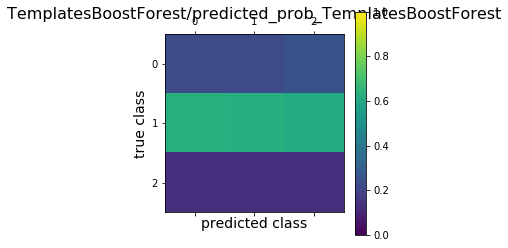

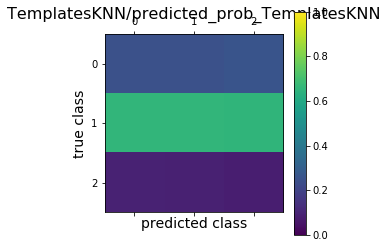

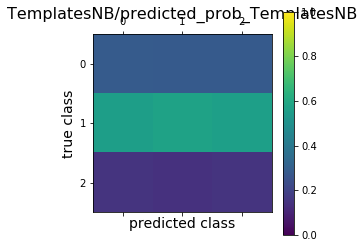

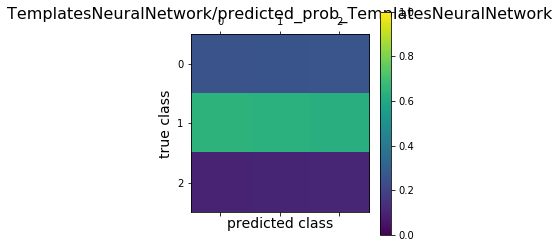

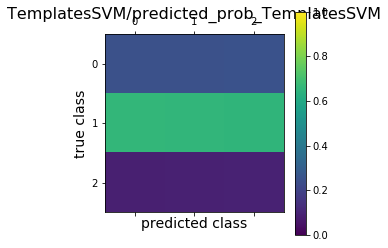

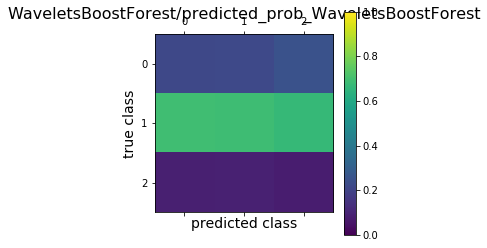

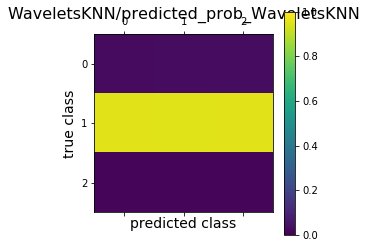

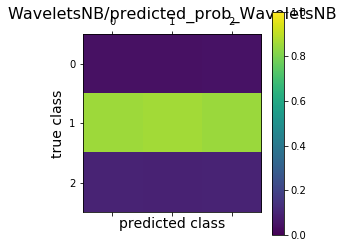

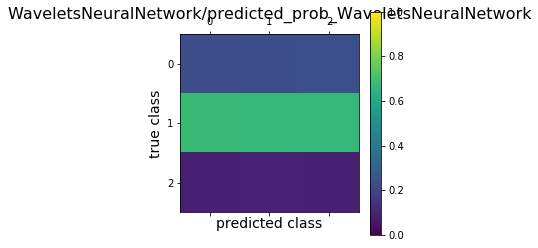

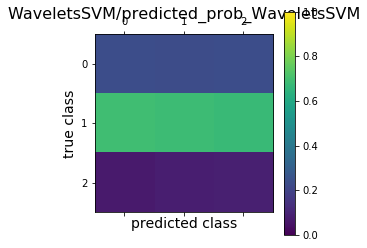

In [12]:
more_data = np.empty((len(metricslist), len(more_names)))
for cc, pair in enumerate(more_class_pairs):
    probm, truthv = read_class_pairs(pair, dirname)
    for count, metric in enumerate(metricslist):
        D = getattr(proclam.metrics, metric)()
        hm = D.evaluate(probm, truthv)
        more_data[count][cc] = hm

/home/aimalz/.local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


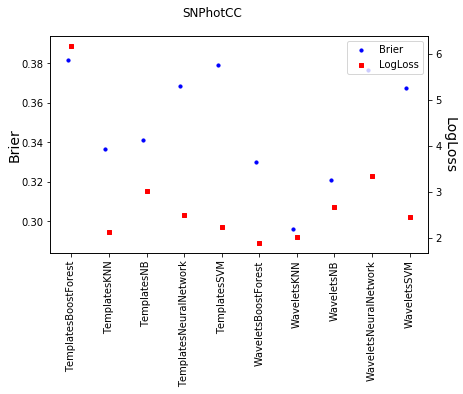

In [13]:
metric_plot(more_names, metricslist, more_data, markerlist, colors, title='SNPhotCC', fileloc=dirname+'snphotccdata.png')

/home/aimalz/.local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


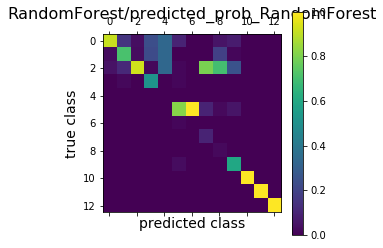

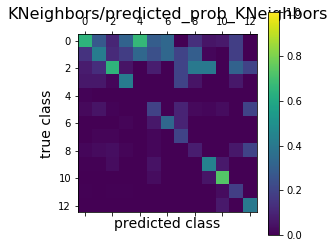

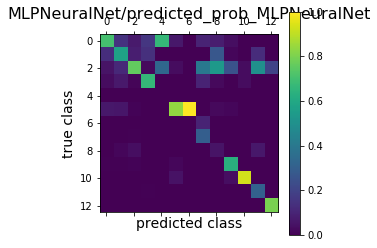

In [14]:
data = np.empty((len(metricslist), len(names)))
for cc, pair in enumerate(class_pairs):
    probm, truthv = read_class_pairs(pair, dirname)
    for count, metric in enumerate(metricslist):
        D = getattr(proclam.metrics, metric)()
        hm = D.evaluate(probm, truthv)
        data[count][cc] = hm

/home/aimalz/.local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


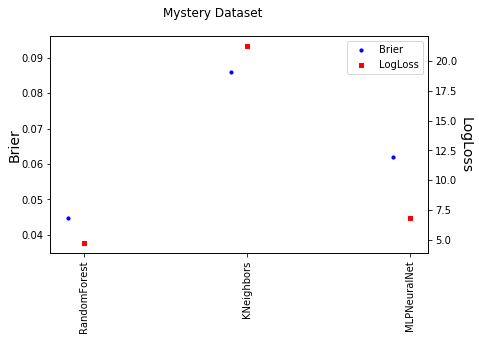

In [15]:
metric_plot(names, metricslist, data, markerlist, colors, title='Mystery Dataset', fileloc=dirname+'mysterydata.png')